<a href="https://colab.research.google.com/github/indra622/tutorials/blob/master/Multi_AI_Agent_Study/Part3_Ch2_02_Self_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain-community langchain-openai python-dotenv chromadb langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
from dotenv import load_dotenv

load_dotenv()


True

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()




In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

class GradeDocuments(BaseModel):
  """ Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(
      description = "Documents are relevant to the question, 'yes' or 'no'"
  )

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """
  You are a grader assessing relevance of a retrieved document to a user question. \n
  It does not need to be a stringent test. The goal is to filter out erropneous retrievals. \n
  If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
  """

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}" ),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = 'agent memory'
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
<ipython-input-10-05ac5e551402>:31: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(model_name = 'gpt-4o-mini', temperature=0)

def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Agent memory in LLM-powered autonomous systems consists of short-term and long-term memory. Short-term memory involves in-context learning, while long-term memory allows agents to retain and recall information over extended periods, often using an external vector store for fast retrieval. This memory structure enables agents to improve their performance by learning from past experiences and interactions.


In [ ]:

class GradeHallucinations(BaseModel):
  """ Binary score for hallucination present in generation answer."""

  binary_score: str = Field(
      description="Answer is grounded in the facts, 'yes' or 'no'"
  )

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

system = """
  You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
  Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


GradeHallucinations(binary_score='yes')

In [ ]:
class GradeAnswer(BaseModel):
  """ Binary score to assess answer addresses question."""

  binary_score: str = Field(
      description="Answer addresses the question, 'yes' or 'no'"
  )

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

system = """
  You are a grader assessing whether an answer addresses / resolves a question \n
  Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question. """

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})


/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


GradeAnswer(binary_score='yes')

In [ ]:

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

system = """
  You are a question re-writer that converts an input question to a better version that is optimized \n
  for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        )
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({'question': question})

'What are the key concepts and applications of agent memory in artificial intelligence?'

In [ ]:
from typing import List
from typing import TypedDict

class GraphState(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
    question: question
    generation: LLM generation
    documents: list of documents
  """

  question: str
  generation: str
  documents: List[str]

In [ ]:

def retrieve(state):
  """
  Retrieve documents

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, documents, that contains retrieved documents
  """

  print("---RETRIEVE---")
  question = state["question"]

  documents = retriever.get_relevant_documents(question)

  return {"documents": documents, "question": question}


def generate(state):

  """
  Generate answer

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation
  """

  print("---GENERATE---")
  question = state["question"]
  documents = state['documents']

  generation = rag_chain.invoke({"context": documents, "question": question})

  return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
  """
  Determines whether the retrieved documents are relevant to the question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, binary_score, that contains binary score
  """

  print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
  question = state["question"]
  documents = state["documents"]

  filtered_docs = []

  for d in documents:
    score = retrieval_grader.invoke(
        {"question": question, "document": d.page_content}
    )


    grade = score.binary_score

    if grade == 'yes':
      print("---GRADE: DOCUMENT RELEVANT---")
      filtered_docs.append(d)

    else:
      print("---GRADE: DOCUMENT NOT RELEVANT---")
      continue

  return {"documents": filtered_docs, "question": question}


def transform_query(state):
  """
  Transform the query to produce a better question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates question key with a re-phrased question
  """

  print("---TRANFORM QUERY---")
  question = state["question"]
  documents = state["documents"]

  better_question = question_rewriter.invoke({"question": question})

  return {"documents": documents, "question": better_question}



def decide_to_generate(state):
  """
  Determines whether to generate an answer, or re-generate a question

  Args:
    state (dict): The current graph state

  Returns:
    str: Binary decision for next node to call
  """

  print("---ASSESS GRADED DOCUMENTS---")
  #state["question"]
  filtered_documents = state["documents"]

  if not filtered_documents:
    print(
        "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
    )
    return "transform_query"
  else:
    print("---DECISION: GENERATE---")
    return "generate"


def grade_generation_v_documents_and_question(state):
  """
  Determines whether the generation is grounded in the document and answers question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, binary_score, that contains binary score
  """

  print("---CHECK HALLUCINATIONS---")

  question = state["question"]
  documents = state["documents"]
  generation = state["generation"]

  score = hallucination_grader.invoke(
      {"documents": documents, "generation": generation}
  )
  grade = score.binary_score

  if grade == "yes":
    print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")

    print("---GRADE GENERATION vs QUESTION---")

    score = answer_grader.invoke(
        {"question": question, "generation": generation}
    )

    grade = score.binary_score

    if grade == "yes":
      print("---DECISION: GENERATION ADDRESSES QUESTION---")
      return "useful"
    else:
      print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
      return "not useful"
  else:
    print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
    return "not supported"


In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": "generate",
        "not useful": END,
        "not supported": "transform_query",
    },
)

app = workflow.compile()

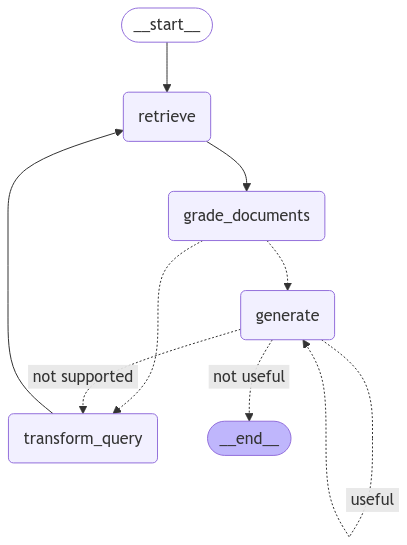

In [ ]:
from IPython.display import display, Image
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [ ]:
from pprint import pprint

inputs = {'question': "explain how the different types of agent memory work?"}

for output in app.stream(inputs):
  for key, value in output.items():
    print(f"Node {key}:")

  print("\n---\n")


print(value['generation'])

---RETRIEVE---
Node retrieve:

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node grade_documents:

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Node generate:

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Node generate:

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Node generate:

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs Q

KeyboardInterrupt: 